In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from spectres import spectres
from scipy.constants import c as speed_of_light
from tqdm import tqdm
import prodimopy.read as pread
import prodimopy.plot as pplot
from numba import njit
from scipy.stats import kendalltau, spearmanr, pearsonr
from scipy.signal import correlate, fftconvolve
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def calc_flux(wl, flux, wlrange):
    """
    Calculates the flux of a flux density in Jy over a range of wavelengths in microns
    """
    mask = (wl >= wlrange[0]) & (wl <= wlrange[1])
    return total_flux(wl[mask], flux[mask])


def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    if wl.size == 0:
        return 0
    flux_lambda = (speed_of_light * 100 / (wl * 1e-4) ** 2) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux

def add_noise(flux, SNR=300):
    """
    SNR = flux/sigma
    """
    noise_level = np.min(flux) / SNR
    noise = np.random.normal(0, noise_level, size=flux.shape)
    return flux + noise

In [139]:
with open('FLiTsData1000.pkl', 'rb') as f:
    df = pickle.load(f)

In [7]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

In [238]:
species = ['NO']
X = []
y = []
total_wl = np.linspace(4.9, 6.5, 1000)
for i, row in tqdm(df.iterrows()):
    # if i in [10, 15, 16, 20, 21, 22]:
    #     continue
    for _ in range(400):
        if np.random.random() > 0.0:
            wl = row['FLiTs Wavelength']
            NH3_wl = row['FLiTs NH3 Wavelength']
            NH3_flux = np.interp(total_wl, NH3_wl, row['FLiTs NH3 Flux'])
            flux = np.interp(total_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
            flux_cont = np.interp(total_wl, wl, row['FLiTs Flux Continuum'])
            flux = add_noise(flux, SNR=300)-flux_cont + NH3_flux
            dat = []
            for specie in species:
                specie_wl = row[f'FLiTs {specie} Wavelength']
                specie_flux = row[f'FLiTs {specie} Flux']
                specie_flux = np.interp(total_wl, specie_wl, specie_flux)
                dat.append(specie_flux+np.random.normal(0,0*abs(np.mean(specie_flux)), len(specie_flux)))
            X.append(flux)
            y.append(dat)
        else:
            wl = row['FLiTs Wavelength']
            flux = np.interp(total_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
            flux_cont = np.interp(total_wl, wl, row['FLiTs Flux Continuum'])
            flux = add_noise(flux, SNR=300)-flux_cont

            X.append(flux)
            y.append([[0] * len(flux)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)


25it [00:19,  1.30it/s]


In [247]:
class SpectralCNN(nn.Module):
    def __init__(self, input_length=10000, num_species=11):
        super(SpectralCNN, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=9, padding=4),   # (B, 16, 10000)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # → (B, 16, 5000)

            nn.Conv1d(32, 64, kernel_size=9, padding=4),  # (B, 32, 5000)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),                  # → (B, 32, 2500)

            nn.Conv1d(64, 128, kernel_size=9, padding=4),  # (B, 64, 2500)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)                   # → (B, 64, 1250)
        )

        # Flatten + Fully connected block (FC block)
        self.fc = nn.Sequential(
            nn.Flatten(),                                 # (B, 64 * 1250)
            nn.Linear(128 * 125, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128 * 125),
            nn.ReLU()
        )

        # Decoder to upsample back to 10000 points
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 125)),

            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),

            nn.ConvTranspose1d(32, num_species, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.encoder(x)
        x = self.fc(x)
        x = self.decoder(x)
        return x

In [248]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = SpectralCNN(input_length=10000, num_species=len(species))

In [254]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
loss_fn = nn.MSELoss()

num_epochs = 3
print_interval = 100
for epoch in tqdm(range(num_epochs)):
    model.train()
    # if epoch % 10 == 0:
    #     learning_rate = 1e-3 * 0.9 ** (epoch)
    #     optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    epoch_loss = 0.0  # To track total loss for the current epoch
    for batch_idx, (xb, yb) in enumerate(dataloader):
        optimizer.zero_grad()

        # Forward pass
        pred = model(xb)

        # Compute loss
        loss = loss_fn(pred, yb)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Track the loss for the epoch
        epoch_loss += loss.item()

        # Print the loss at specified intervals
        if (batch_idx + 1) % print_interval == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(dataloader)}], Loss: {loss.item():.2e}")
            # pass

    # Print average loss for the entire epoch
    avg_epoch_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {avg_epoch_loss:.2e}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch [1/3], Batch [100/313], Loss: 1.34e-07
Epoch [1/3], Batch [200/313], Loss: 1.23e-07
Epoch [1/3], Batch [300/313], Loss: 1.47e-07


 33%|███▎      | 1/3 [00:37<01:15, 37.79s/it]

Epoch [1/3] completed. Average Loss: 1.27e-07


 33%|███▎      | 1/3 [00:41<01:22, 41.45s/it]


KeyboardInterrupt: 

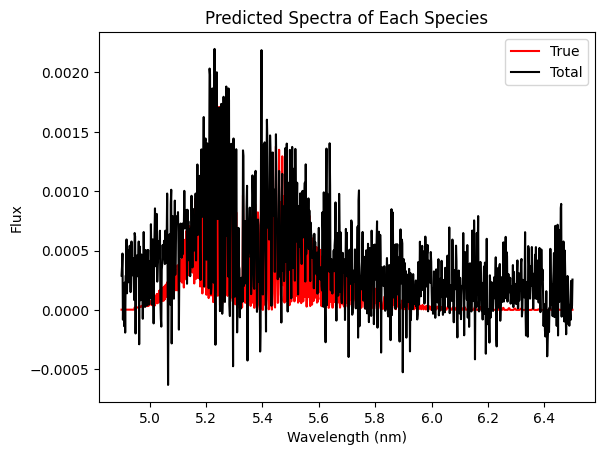

In [255]:
num = 10
x = X[num]  # shape: (10000,)
x = torch.tensor(x).unsqueeze(0).float()  # (1, 10000)
Y = torch.tensor(y[num]).squeeze(0).float()   # shape: (11, 10000)

# Sum over species to reconstruct the mixed signal
y_reconstructed = Y
model.eval()
with torch.inference_mode():
    output = model(x)  # (1, 11, 10000)

# Plot individual species' contributions
import matplotlib.pyplot as plt
total = np.zeros(len((output[0, 0].numpy())))
for i in range(1):
    total += output[0, 0].numpy()
    # plt.plot(total_wl, output[0, i].numpy(), label=f"{species[8]}")
# plt.plot(total_wl, total, label="Total", color='black')
plt.plot(total_wl, y_reconstructed, label='True', color='red')
plt.plot(total_wl, total, label="Total", color='black')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux')
# plt.xlim(5, 5.6)
plt.legend()
plt.title("Predicted Spectra of Each Species")
plt.show()

In [37]:
with open('FLiTsData100.pkl', 'rb') as f:
    df = pickle.load(f)

In [235]:
X_new = []
y_new = []
for i, row in tqdm(df.iterrows()):
    if i in [10, 15, 16, 20, 21, 22]:
        continue
    wl = row['FLiTs Wavelength']
    NH3_wl = row['FLiTs NO Wavelength']
    NH3_flux = np.interp(total_wl, NH3_wl, row['FLiTs NO Flux'])
    flux = np.interp(total_wl, wl, row['FLiTs Flux'] + row['FLiTs Flux Continuum'])
    flux_cont = np.interp(total_wl, wl, row['FLiTs Flux Continuum'])
    flux = add_noise(flux, SNR=300)-flux_cont + NH3_flux
    X_new.append(flux)
    y_new.append(NH3_flux)

X_new = np.array(X_new)
y_new = np.array(y_new)

25it [00:00, 556.12it/s]


Real AUC: 0.0002777366451110482 | CNN AUC: 0.00030648791873538484


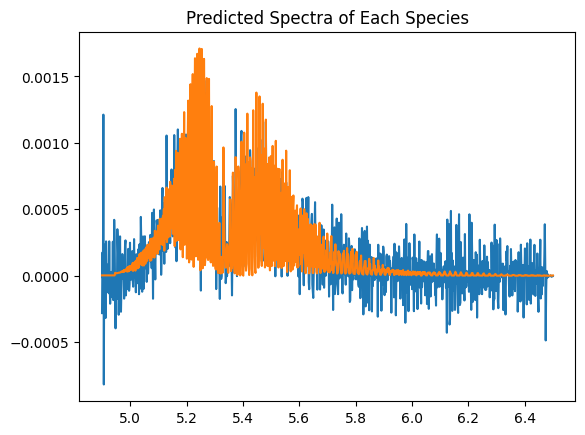

Real AUC: 0.00032929667772762784 | CNN AUC: 0.00030648791873538484


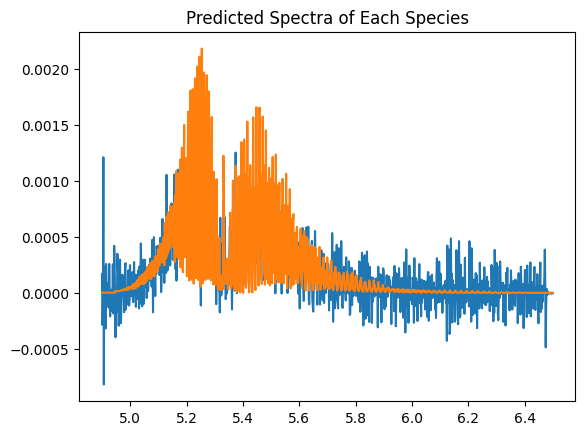

Real AUC: 0.000408918163401489 | CNN AUC: 0.00030648791873538484


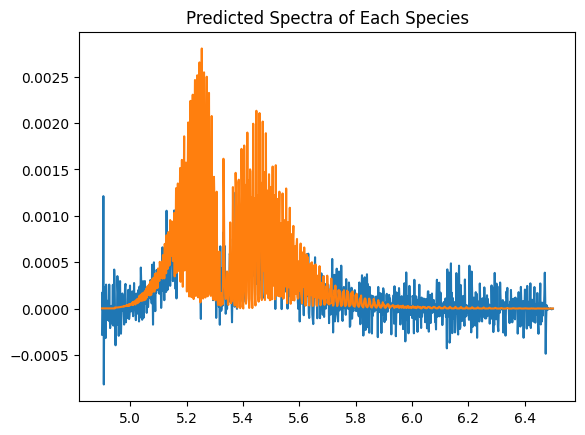

Real AUC: 0.0005375877686463529 | CNN AUC: 0.00030648791873538484


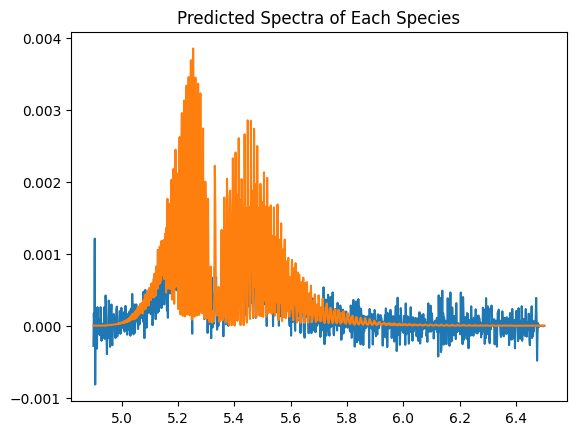

Real AUC: 0.0007537860940197909 | CNN AUC: 0.00030648791873538484


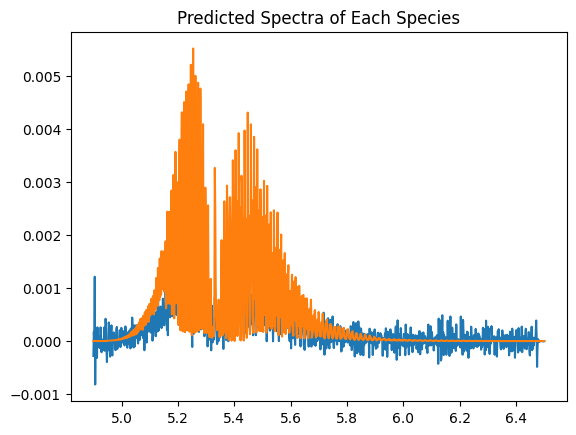

Real AUC: 0.0001942559911293599 | CNN AUC: 0.00030648791873538484


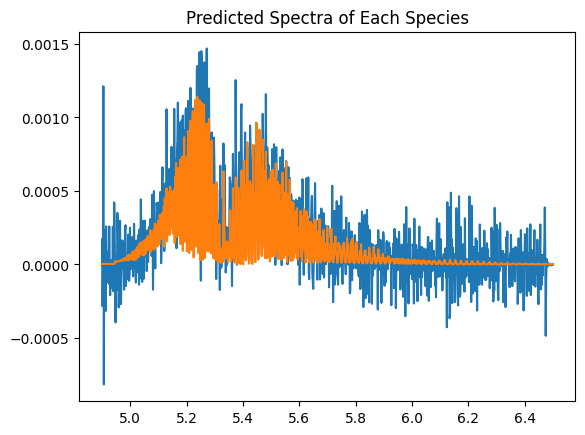

Real AUC: 0.0002633365701237289 | CNN AUC: 0.00030648791873538484


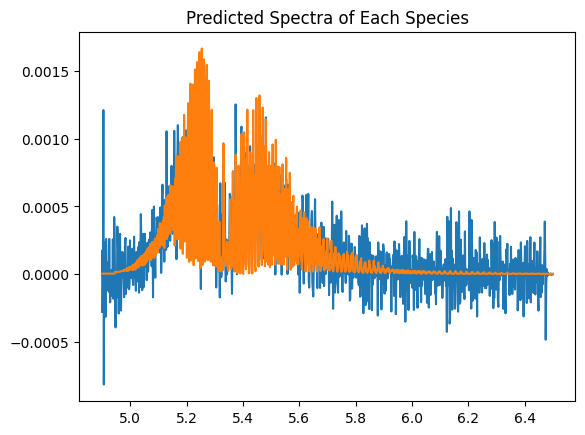

Real AUC: 0.00034321691917747857 | CNN AUC: 0.00030648791873538484


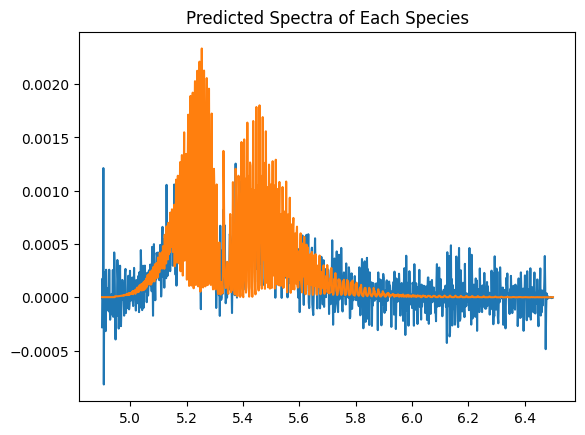

Real AUC: 0.00047311187752916773 | CNN AUC: 0.00030648791873538484


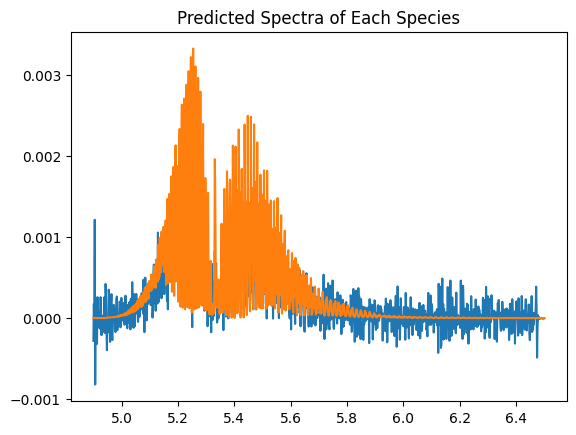

Real AUC: 0.0006794481582692252 | CNN AUC: 0.00030648791873538484


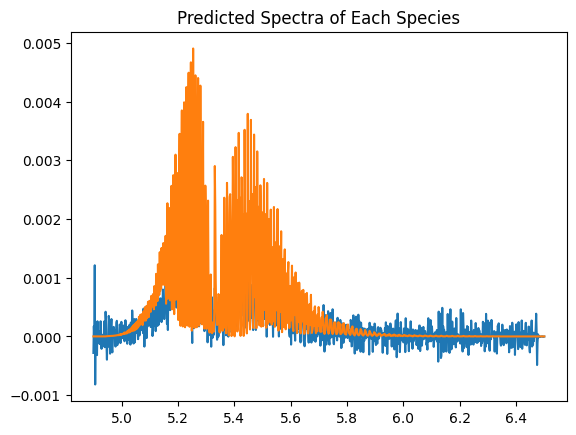

Real AUC: 0.00015947755477367951 | CNN AUC: 0.00030648791873538484


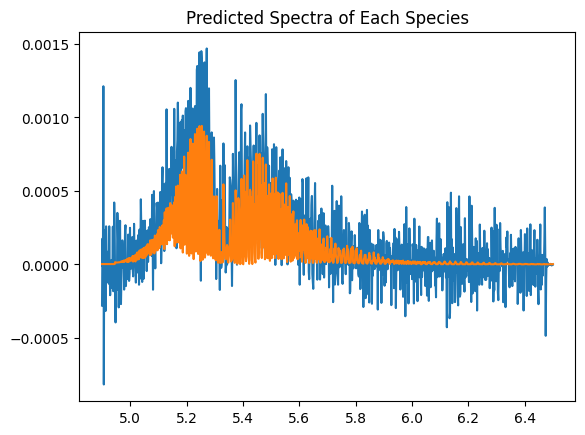

Real AUC: 0.00026754522449193757 | CNN AUC: 0.00030648791873538484


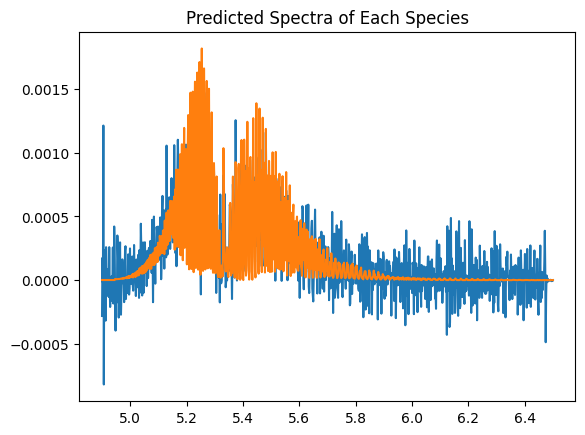

Real AUC: 0.000398097642710088 | CNN AUC: 0.00030648791873538484


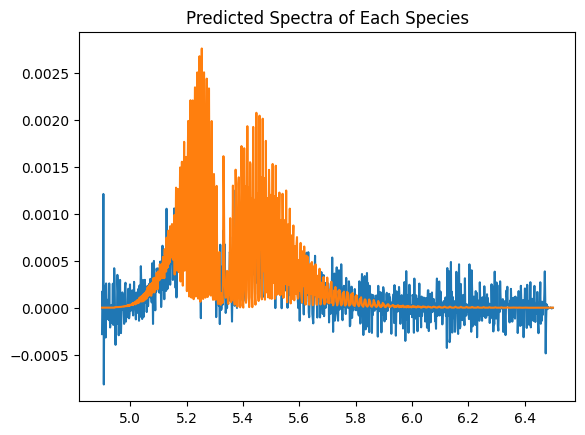

Real AUC: 0.0005896015622358666 | CNN AUC: 0.00030648791873538484


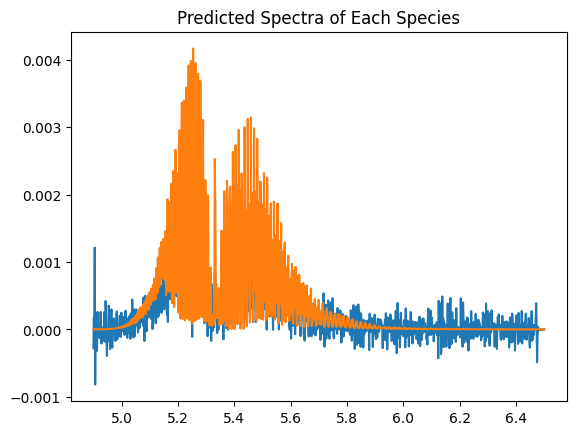

Real AUC: 0.00014901923822685002 | CNN AUC: 0.00030648791873538484


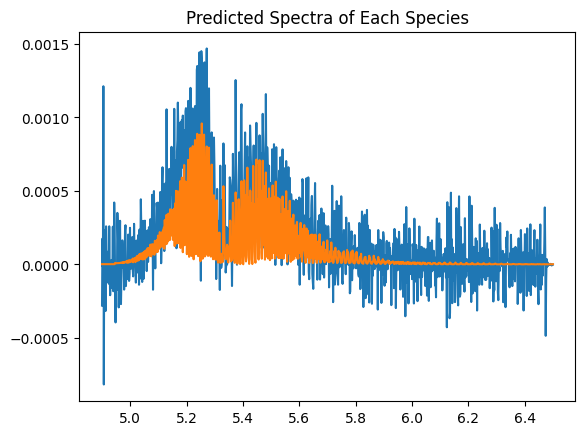

Real AUC: 0.00029568331357469375 | CNN AUC: 0.00030648791873538484


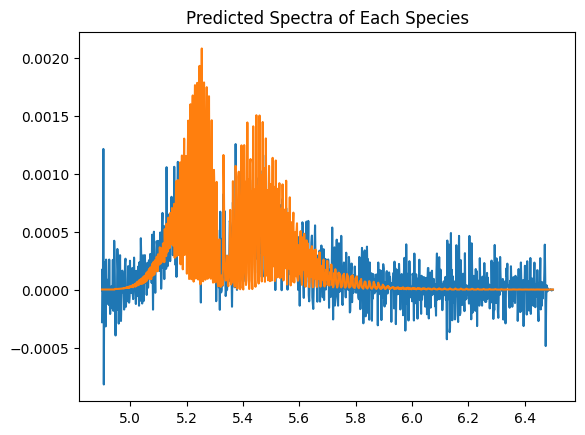

Real AUC: 0.0004725106845295808 | CNN AUC: 0.00030648791873538484


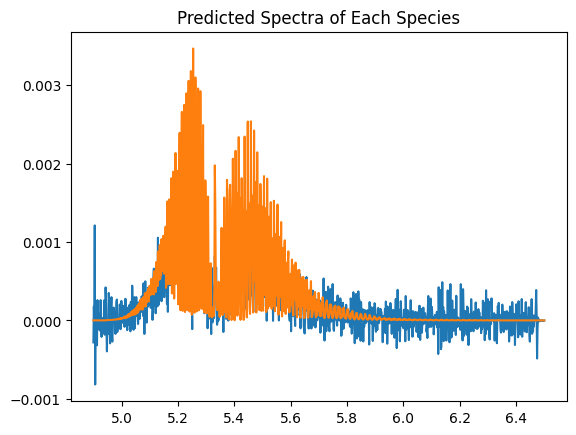

Real AUC: 0.0001557388457463891 | CNN AUC: 0.00030648791873538484


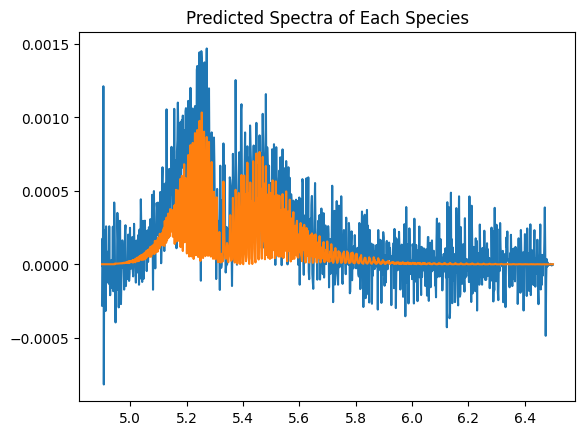

Real AUC: 0.0003463840711720886 | CNN AUC: 0.00030648791873538484


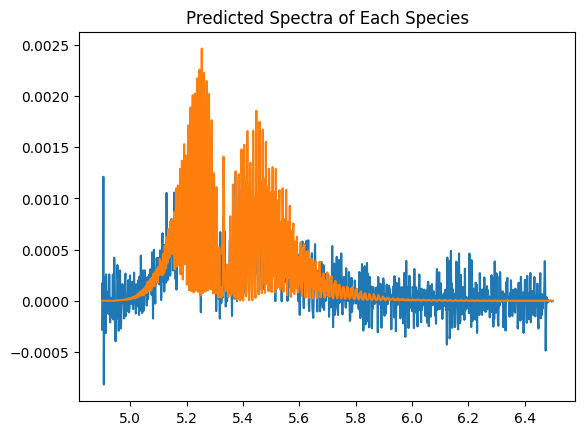

In [237]:
for i in range(19):
    x_new = X_new[i]  # shape: (10000,)
    x_new = torch.tensor(x_new).unsqueeze(0).float()
    with torch.inference_mode():
        output = model(x_new)
    # total_wl = np.linspace(4.9, 7, 1000)
    plt.plot(total_wl, output[0, 0].numpy())
    # plt.legend()
    plt.plot(total_wl, y_new[i])
    print(f'Real AUC: {np.trapezoid(y_new[i], total_wl)} | CNN AUC: {np.trapezoid(output[0, 0].numpy(), total_wl)}')
    plt.title("Predicted Spectra of Each Species")
    # plt.xlim(4.8, 6)
    plt.show()

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu
